<h1 style='background:#4686C8; border:0; color:#5CE1E6'><center>SUDOKU SOLVER </center></h1> 
<p ><center>by Ernar Naryshov</center><p>

Solving any sudoku puzzles from an unsolved images and videos

The project consists of three parts :

**Part I : Digit classification model**

**Part II : Detection and reading Sudoku puzzle from an image or video**
    
**Part III : Solving the sudoku puzzle**

 <h1 style='background:#4686C8; border:0; color:#5CE1E6'><center>PART ONE</center></h1> 

 <a id="1"></a>
# **<span style="color:#4686C8;">IMPORTING THE LIBRARIES</span>**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
from glob import glob

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from pathlib import Path
from PIL import Image



<a id="2"></a>
# **<span style="color:#4686C8;">DIGIT CLASSIFICATION MODEL</span>** 

**In this section :**
- Loading data
- Splitting data into training, testing and validation sets
- Preprocessing the data
- Model building and training

<a id="3"></a>
# **<span style="color:#4686C8;">LOADING DATA</span>** 

In [3]:

data = os.listdir(r"data/archive (3)/Digits")
data_X = []
data_y = []
data_classes = len(data)

for i in range(0, data_classes):
    data_list = os.listdir(r"data/archive (3)/Digits" +"/"+str(i))
    for j in data_list:
        pic = cv2.imread(r"data/archive (3)/Digits" +"/"+str(i)+"/"+j)
        pic = cv2.resize(pic, (32,32))
        data_X.append(pic)
        data_y.append(i)
        
if(len(data_X) == len(data_y)):
    print("Total datas : ", len(data_X))
    
data_X = np.array(data_X)
data_y = np.array(data_y)

<a id="4"></a>
# **<span style="color:#4686C8;">SPLITTING DATASET</span>** 

In [3]:

train_X, test_X, train_y, test_y = train_test_split(data_X,data_y,test_size=0.05)
train_X, valid_X, train_y, valid_y = train_test_split(train_X,train_y,test_size=0.2)
print("Training Set Shape = ",train_X.shape)
print("Validation Set Shape = ",valid_X.shape)
print("Test Set Shape = ",test_X.shape)

Training Set Shape =  (7721, 32, 32, 3)
Validation Set Shape =  (1931, 32, 32, 3)
Test Set Shape =  (508, 32, 32, 3)


<a id="5"></a>
# **<span style="color:#4686C8;">DATA PREPROCESSING</span>** 

In [4]:

def Prep(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    img = cv2.equalizeHist(img) 
    img = img/255 
    return img

train_X = np.array(list(map(Prep, train_X)))
test_X = np.array(list(map(Prep, test_X)))
valid_X= np.array(list(map(Prep, valid_X)))

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2],1)
valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], valid_X.shape[2],1)

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
datagen.fit(train_X)

In [5]:

train_y = to_categorical(train_y, data_classes)
test_y = to_categorical(test_y, data_classes)
valid_y = to_categorical(valid_y, data_classes)

<a id="6"></a>
# **<span style="color:#4686C8;">MODEL BUILDING</span>** 

**Building a Convolutional Neural Network :**
- Initialising the Convnet
- Defining by adding layers
- Compile the Convnet
- Train the Convnet

In [6]:

model = Sequential([
    Conv2D(60, (5,5), activation = 'relu', padding = 'same', input_shape = (32,32,1)),
    Conv2D(60, (5,5), activation = 'relu', padding=  'same'),
    MaxPooling2D(pool_size = (2,2)),
    
    Conv2D(30, (5,5), activation = 'relu', padding = 'same'),
    Conv2D(30, (5,5), activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    Dropout(0.50),
    
    Flatten(),
    Dense(500, activation = 'relu'),
    Dropout(0.5),
    Dense(10, activation = 'softmax')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 30)        45030     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 30)        22530     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 30)         0         
 2D)                                                    

In [8]:

optimizer = RMSprop(learning_rate = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)
model.compile(loss = 'categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

In [9]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', patience=5)

from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystop = EarlyStopping(monitor='val_loss', patience=5)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)




In [11]:

history = model.fit(datagen.flow(train_X, train_y, batch_size = 32),
                   epochs = 30,
                   validation_data = (valid_X, valid_y),
                   verbose = 1,
                   steps_per_epoch = 200,                         
                   callbacks=[earlystop, checkpoint])

Epoch 1/30
200/200 [==============================] - 101s 497ms/step - loss: 0.9825 - accuracy: 0.6580 - val_loss: 0.0955 - val_accuracy: 0.9694
Epoch 2/30
200/200 [==============================] - 99s 494ms/step - loss: 0.2501 - accuracy: 0.9241 - val_loss: 0.0391 - val_accuracy: 0.9886
Epoch 3/30
200/200 [==============================] - 101s 503ms/step - loss: 0.1697 - accuracy: 0.9489 - val_loss: 0.0360 - val_accuracy: 0.9886
Epoch 4/30
200/200 [==============================] - 99s 497ms/step - loss: 0.1304 - accuracy: 0.9616 - val_loss: 0.0152 - val_accuracy: 0.9959
Epoch 5/30
200/200 [==============================] - 100s 501ms/step - loss: 0.1205 - accuracy: 0.9663 - val_loss: 0.0224 - val_accuracy: 0.9933
Epoch 6/30
200/200 [==============================] - 100s 498ms/step - loss: 0.1055 - accuracy: 0.9715 - val_loss: 0.0244 - val_accuracy: 0.9933
Epoch 7/30
200/200 [==============================] - 99s 497ms/step - loss: 0.0852 - accuracy: 0.9757 - val_loss: 0.0431 - va

In [50]:
# model.save('data.h5')

In [12]:

score = model.evaluate(test_X, test_y, verbose = 0)
print("Test Score : ", score[0])
print("Test Accuracy : ", score[1])

Test Score :  0.04244762286543846
Test Accuracy :  0.9783464670181274


In [2]:
model = tf.keras.models.load_model('data/best_model.h5')

# <h1 style='background:#4686C8; border:0; color:#5CE1E6'><center>PART TWO</center></h1> 

<a id="7"></a>
# **<span style="color:#4686C8;">READING THE SUDOKU PUZZLE </span>**

**In this section :**
- Read an image or video from the dataset
- Preprocess the image

sudoku2.jpg


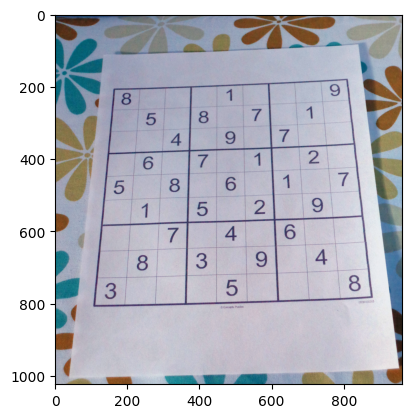

In [11]:

folder=r"data/sudoku_images/"

a = random.choice(os.listdir(folder))
print(a)
sudoku_a = cv2.imread(folder + '/' + a)
plt.figure()
plt.imshow(sudoku_a)
plt.show()

In [12]:
sudoku_a = cv2.resize(sudoku_a, (450,450))

def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = preprocess(sudoku_a)

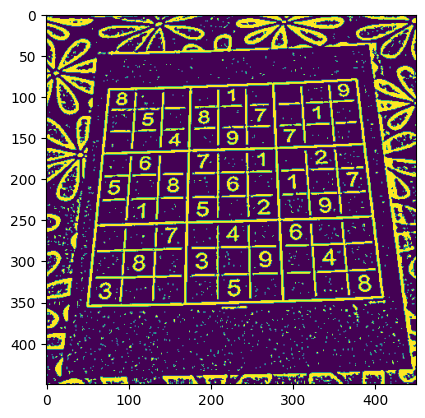

In [13]:
plt.figure()
plt.imshow(threshold)
plt.show()

<a id="8"></a>
# **<span style="color:#4686C8;">DETECTING CONTOUR</span>**

- Detect the biggest contour of the image
- Reshaping the outline to get the cropped and well-aligned sudoku

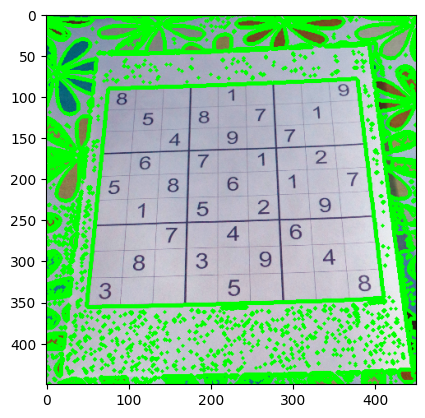

In [14]:
contour_1 = sudoku_a.copy()
contour_2 = sudoku_a.copy()
contour, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour, -1, (0,255,0), 3)

plt.figure()
plt.imshow(contour_1)
plt.show()

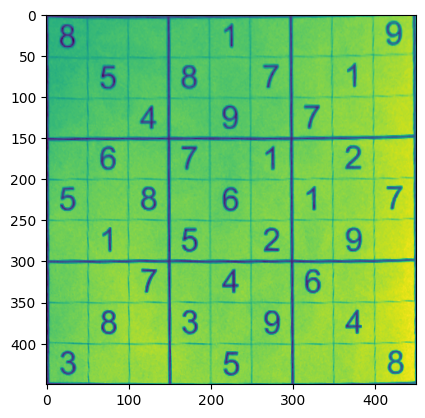

In [15]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02*peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest, max_area

def reframe(points):
    points = points.reshape((4,2))
    points_new = np.zeros((4,1,2), dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis = 1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img, 9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r, 9)
        for box in cols:
            boxes.append(box)
    return boxes

black_img = np.zeros((450,450,3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2, biggest, -1, (0,255,0), 10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    imagewrap = cv2.warpPerspective(sudoku_a, matrix, (450,450))
    imagewrap = cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)
    
plt.figure()
plt.imshow(imagewrap)
plt.show()

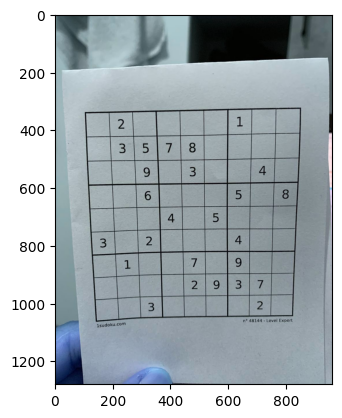

In [16]:
puzzle = cv2.imread("data/sudoku_images/s.jpg")

plt.figure()
plt.imshow(puzzle)
plt.show()

In [9]:
# img.shape

In [68]:
# cap.release()
# cv2.destroyAllWindows()

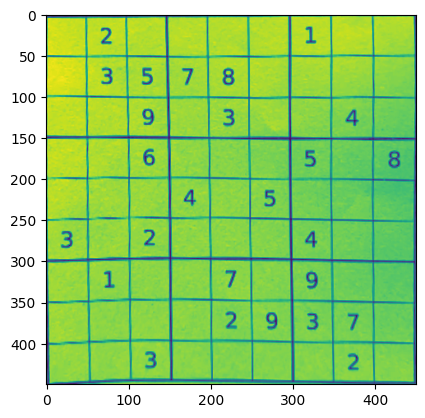

In [17]:
puzzle = cv2.resize(puzzle, (450, 450))

su_puzzle = preprocess(puzzle)

su_contour_1 = su_puzzle.copy()
# su_contour_2 = sudoku_a.copy()
su_contour, hierarchy = cv2.findContours(su_puzzle, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(su_contour_1, su_contour, -1, (0,255,0), 3)

black_img = np.zeros((450,450,3), np.uint8)
su_biggest, su_maxArea = main_outline(su_contour)
if su_biggest.size != 0:
    su_biggest = reframe(su_biggest)
    # cv2.drawContours(su_contour_2,su_biggest,-1, (0,255,0),10)
    su_pts1 = np.float32(su_biggest)
    su_pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    su_matrix = cv2.getPerspectiveTransform(su_pts1,su_pts2)  
    su_imagewrap = cv2.warpPerspective(puzzle,su_matrix,(450,450))
    su_imagewrap =cv2.cvtColor(su_imagewrap, cv2.COLOR_BGR2GRAY)
    

    
plt.figure()
plt.imshow(su_imagewrap)
plt.show()

<a id="9"></a>
# **<span style="color:#4686C8;">SPLITTING THE CELLS AND CLASSIFYING DIGITS</span>**

- Splitting the sudoku box in 81 cell with empty spaces or digits
- Cropping the cells to avoid misdetection of boundary lines as digits
- Using the model to classify the digits in the cells such that the empty cells are classified as zero
- Getting the detected output in the form of an array of 81 digits

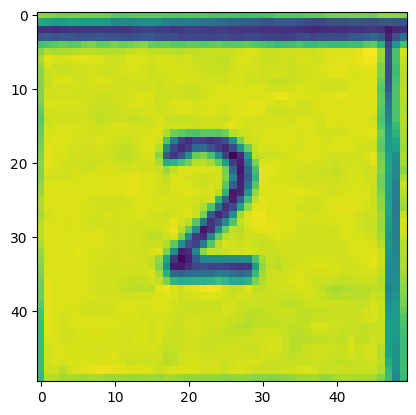

In [18]:
sudoku_cell = splitcells(su_imagewrap)

plt.figure()
plt.imshow(sudoku_cell[1])
plt.show()

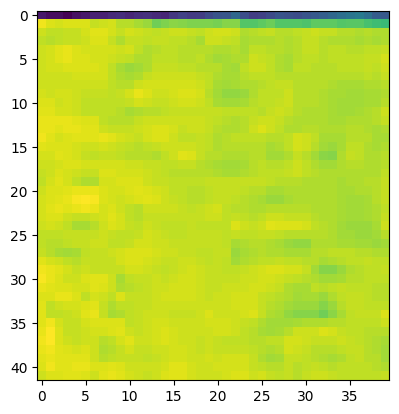

In [19]:
def CropCell(cells):
    cells_cropped = []
    for image in cells:
        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        cells_cropped.append(img)
    return cells_cropped

sudoku_cell_cropped = CropCell(sudoku_cell)

plt.figure()
plt.imshow(sudoku_cell_cropped[0])
plt.show()

In [20]:
def read_cells(cell, model):
    result = []

    for image in cell:
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] - 4]
        img = cv2.resize(img, (32,32))
        img = img/255
        img = img.reshape(1,32,32,1)
        
        
        predictions = model.predict(img)
        classIndex=  np.argmax(predictions, axis = 1)
        probabilityValue = np.amax(predictions)
        
        if(probabilityValue > 0.65):
            result.append(classIndex[0])
        else:
            result.append(0)
    return result

grid = read_cells(sudoku_cell_cropped, model)
grid = np.asarray(grid)


1/1 [==============================] - 0s 64ms/step


# <h1 style='background:#4686C8; border:0; color:#5CE1E6'><center>PART THREE</center></h1> 

<a id="9"></a>
# **<span style="color:#4686C8;">SOLVING THE SUDOKU</span>**

- Reshaping the array into a 9x9 matrix
- Solving the matrix using recursion

In [21]:
grid = np.reshape(grid, (9,9))
grid


array([[0, 2, 0, 0, 0, 0, 1, 0, 0],
       [0, 3, 5, 7, 8, 0, 0, 0, 0],
       [0, 0, 9, 0, 3, 0, 0, 4, 0],
       [0, 0, 6, 0, 0, 0, 5, 0, 8],
       [0, 0, 0, 4, 0, 5, 0, 0, 0],
       [3, 0, 2, 0, 0, 0, 4, 0, 0],
       [0, 1, 0, 0, 7, 0, 9, 0, 0],
       [0, 0, 0, 0, 2, 9, 3, 7, 0],
       [0, 0, 3, 0, 0, 0, 0, 2, 0]], dtype=int64)

In [22]:
gridU = grid.copy()

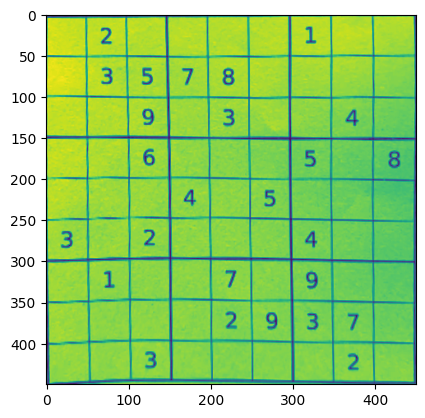

In [23]:
plt.figure()
plt.imshow(su_imagewrap)
plt.show()
# cv2.imwrite('data/segmented_image.jpg', su_imagewrap)


In [24]:
su_imagewrap.shape

(450, 450)

In [25]:
def findNextCellToFill(grid, i, j):
        for x in range(i,9):
                for y in range(j,9):
                        if grid[x][y] == 0:
                                return x,y
        for x in range(0,9):
                for y in range(0,9):
                        if grid[x][y] == 0:
                                return x,y
        return -1,-1

def isValid(grid, i, j, e):
        rowOk = all([e != grid[i][x] for x in range(9)])
        if rowOk:
                columnOk = all([e != grid[x][j] for x in range(9)])
                if columnOk:
                        secTopX, secTopY = 3 *(i//3), 3 *(j//3)  
                        for x in range(secTopX, secTopX+3):
                                for y in range(secTopY, secTopY+3):
                                        if grid[x][y] == e:
                                                return False
                        return True
        return False

def solveSudoku(grid, i=0, j=0):
        i,j = findNextCellToFill(grid, i, j)
        if i == -1:
                return True
        for e in range(1,10):
                if isValid(grid,i,j,e):
                        grid[i][j] = e
                        if solveSudoku(grid, i, j):
                                return True
                        grid[i][j] = 0
        return False

In [26]:
solveSudoku(grid)

True

In [27]:
grid

array([[6, 2, 7, 9, 5, 4, 1, 8, 3],
       [4, 3, 5, 7, 8, 1, 6, 9, 2],
       [1, 8, 9, 6, 3, 2, 7, 4, 5],
       [7, 4, 6, 2, 9, 3, 5, 1, 8],
       [8, 9, 1, 4, 6, 5, 2, 3, 7],
       [3, 5, 2, 8, 1, 7, 4, 6, 9],
       [2, 1, 4, 3, 7, 8, 9, 5, 6],
       [5, 6, 8, 1, 2, 9, 3, 7, 4],
       [9, 7, 3, 5, 4, 6, 8, 2, 1]], dtype=int64)

In [28]:
gridU

array([[0, 2, 0, 0, 0, 0, 1, 0, 0],
       [0, 3, 5, 7, 8, 0, 0, 0, 0],
       [0, 0, 9, 0, 3, 0, 0, 4, 0],
       [0, 0, 6, 0, 0, 0, 5, 0, 8],
       [0, 0, 0, 4, 0, 5, 0, 0, 0],
       [3, 0, 2, 0, 0, 0, 4, 0, 0],
       [0, 1, 0, 0, 7, 0, 9, 0, 0],
       [0, 0, 0, 0, 2, 9, 3, 7, 0],
       [0, 0, 3, 0, 0, 0, 0, 2, 0]], dtype=int64)

In [29]:
if solveSudoku(grid)==False:
    print("Solution don't exist. Model misread digits.")
else:
    print('Solved')


Solved


In [30]:
result = grid.copy()
print(result)


[[6 2 7 9 5 4 1 8 3]
 [4 3 5 7 8 1 6 9 2]
 [1 8 9 6 3 2 7 4 5]
 [7 4 6 2 9 3 5 1 8]
 [8 9 1 4 6 5 2 3 7]
 [3 5 2 8 1 7 4 6 9]
 [2 1 4 3 7 8 9 5 6]
 [5 6 8 1 2 9 3 7 4]
 [9 7 3 5 4 6 8 2 1]]


In [31]:
for i in range(9):
    for j in range(9):
        if gridU[i,j]==0:
            result[i,j] = grid[i,j] 
        elif gridU[i,j] != 0:
            result[i,j] = 0
            
print(result)

[[6 0 7 9 5 4 0 8 3]
 [4 0 0 0 0 1 6 9 2]
 [1 8 0 6 0 2 7 0 5]
 [7 4 0 2 9 3 0 1 0]
 [8 9 1 0 6 0 2 3 7]
 [0 5 0 8 1 7 0 6 9]
 [2 0 4 3 0 8 0 5 6]
 [5 6 8 1 0 0 0 0 4]
 [9 7 0 5 4 6 8 0 1]]


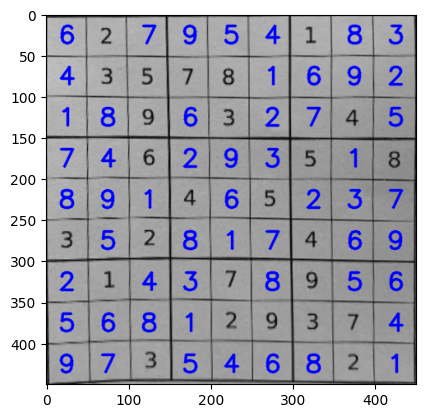

In [32]:
output_img = cv2.imread('data/sudoku_images/segmented_image.jpg')

for i in range(9):
    for j in range(9):
        x = j * 50
        y = i * 50
        if result[i][j]!=0:
            cv2.putText(output_img, str(result[i][j]), (x+15, y+35), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

plt.imshow(output_img)
plt.show()


<a id="11"></a>
<h1 style='background:#4686C8; border:0; color:#5CE1E6'><center>Video Streaming</center></h1> 


In [70]:
import copy

# cap = cv2.VideoCapture('data/su_videos/video_su.mp4')
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('data/su_videos/360p.mp4')



while True:
    ret, frame = cap.read()
    puzzle1 = frame.copy()
    
    # Resizing the puzzle to be solved
    puzzle1 = cv2.resize(puzzle1, (450, 450))

    # Preprocessing puzzle
    su_puzzle1 = preprocess(puzzle1)

    # Finding the outline of the sudoku puzzle in the image
    su_contour_11 = su_puzzle1.copy()
    # su_contour_2 = sudoku_a.copy()
    su_contour1, hierarchy1 = cv2.findContours(su_puzzle1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(su_contour_11, su_contour1, -1, (0,255,0), 3)

    black_img1 = np.zeros((450,450,3), np.uint8)
    su_biggest1, su_maxArea1 = main_outline(su_contour1)
    su_imagewrap1 = 0
    if su_biggest1.size != 0:
        su_biggest1 = reframe(su_biggest1)
        # cv2.drawContours(su_contour_2,su_biggest,-1, (0,255,0),10)
        su_pts11 = np.float32(su_biggest1)
        su_pts21 = np.float32([[0,0],[450,0],[0,450],[450,450]])
        su_matrix1 = cv2.getPerspectiveTransform(su_pts11,su_pts21)  
        su_imagewrap1 = cv2.warpPerspective(puzzle1,su_matrix1,(450,450))
        su_imagewrap1 =cv2.cvtColor(su_imagewrap1, cv2.COLOR_BGR2GRAY)
        # su_imagewrap1 = cv2.cvtColor(su_imagewrap1, cv2.COLOR_BGR2RGB)


    
    sudoku_cell1 = splitcells(su_imagewrap1)
    sudoku_cell_cropped1 = CropCell(sudoku_cell1)
    
    grid1 = read_cells(sudoku_cell_cropped1, model)
    grid1 = np.asarray(grid1)
    grid1 = np.reshape(grid1, (9,9))
    
    gridU1 = grid1.copy()
    print(gridU1)
    print()
    
    
    solveSudoku(grid1)
    print(grid1)
    print()
    result1 = grid1.copy()

    

    for i in range(9):
        for j in range(9):
            if gridU1[i,j]==0:
                result1[i,j] = grid1[i,j] 
            elif gridU1[i,j] != 0:
                result1[i,j] = 0


    print()            
    print(result1)
    # su_imagewrap1 = cv2.cvtColor(su_imagewrap1, cv2.COLOR_GRAY2RGB)
    imgq = su_imagewrap1.copy()
    # imgq = copy.deepcopy(su_imagewrap1)
    # imgq = cv2.cvtColor(imgq, cv2.COLOR_GRAY2RGB)

    for i in range(9):
        for j in range(9):
            x1 = j * 50
            y1 = i * 50
            if result1[i][j]!=0:
                cv2.putText(imgq, str(result1[i][j]), (x1+15, y1+35), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                # cv2.putText(img, str(result1[i][j]), (x1+15, y1+35), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3, cv2.LINE_AA)

    

    cv2.imshow('Sudoku', imgq)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
    

1/1 [==============================] - 0s 26ms/step
[[0 2 0 0 0 0 0 0 0]
 [0 3 5 0 0 0 0 0 0]
 [0 0 9 0 3 0 0 0 0]
 [0 0 6 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [3 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 9 0 0]
 [0 0 0 0 2 0 3 0 0]
 [0 0 3 0 0 0 0 2 0]]

[[1 2 4 5 6 7 8 3 9]
 [6 3 5 2 8 9 4 7 1]
 [7 8 9 1 3 4 6 5 2]
 [4 5 6 7 9 2 1 8 3]
 [8 9 7 3 1 5 2 6 4]
 [3 1 2 8 4 6 7 9 5]
 [2 7 8 4 5 3 9 1 6]
 [5 6 1 9 2 8 3 4 7]
 [9 4 3 6 7 1 5 2 8]]


[[1 0 4 5 6 7 8 3 9]
 [6 0 0 2 8 9 4 7 1]
 [7 8 0 1 0 4 6 5 2]
 [4 5 0 7 9 2 1 8 3]
 [8 9 7 3 1 5 2 6 4]
 [0 1 0 8 4 6 7 9 5]
 [2 7 8 4 5 3 0 1 6]
 [5 6 1 9 0 8 0 4 7]
 [9 4 0 6 7 1 5 0 8]]
1/1 [==============================] - 0s 25ms/step
[[0 2 0 0 0 0 0 0 0]
 [0 3 5 0 0 0 0 0 0]
 [0 0 9 0 3 0 0 0 0]
 [0 0 6 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [3 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 9 0 0]
 [0 0 0 0 2 0 3 0 0]
 [0 0 3 0 0 0 0 2 0]]

[[1 2 4 5 6 7 8 3 9]
 [6 3 5 2 8 9 4 7 1]
 [7 8 9 1 3 4 6 5 2]
 [4 5 6 7 9 2 1 8 3]
 [8 9 7 3 1 5 2 6 4]
 [3 1 2 8 4 6 7 9 5]
 [2 7 

In [34]:
cap.release()
cv2.destroyAllWindows()

<a id="11"></a>
<h1 style='background:#4686C8; border:0; color:#5CE1E6'><center>Features</center></h1> 

 <a id="1"></a>
# **<span style="color:#4686C8;">Sudoku Generator</span>**

In [63]:
import random

def generate_sudoku(difficulty):
    grid = [[0 for _ in range(9)] for _ in range(9)]
    
    for i in range(9):
        for j in range(9):
            grid[i][j] = (i * 3 + i // 3 + j) % 9 + 1
    
    num_cells_to_remove = 0
    if difficulty == 'easy':
        num_cells_to_remove = random.randint(40, 45)
    elif difficulty == 'medium':
        num_cells_to_remove = random.randint(46, 50)
    elif difficulty == 'hard':
        num_cells_to_remove = random.randint(51, 55)
    
    for _ in range(num_cells_to_remove):
        i, j = random.randint(0, 8), random.randint(0, 8)
        while grid[i][j] == 0:
            i, j = random.randint(0, 8), random.randint(0, 8)
        grid[i][j] = 0
    
    return grid

generate_sudoku('hard')


[[1, 0, 0, 0, 0, 6, 0, 8, 0],
 [0, 0, 6, 7, 0, 9, 1, 2, 0],
 [7, 8, 0, 0, 0, 0, 0, 0, 0],
 [2, 0, 0, 0, 0, 0, 8, 0, 0],
 [5, 6, 7, 0, 9, 1, 0, 0, 0],
 [8, 0, 0, 0, 3, 4, 0, 0, 0],
 [0, 0, 5, 0, 7, 0, 0, 0, 2],
 [6, 0, 0, 9, 0, 0, 0, 4, 0],
 [9, 0, 0, 3, 4, 0, 0, 0, 0]]

In [65]:
task = generate_sudoku('hard')
print(task)

[[1, 2, 0, 4, 0, 6, 0, 8, 0], [0, 0, 6, 7, 0, 0, 0, 0, 0], [7, 0, 0, 0, 2, 0, 4, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [5, 0, 0, 8, 9, 0, 0, 3, 4], [0, 0, 1, 2, 0, 0, 0, 6, 0], [0, 4, 0, 6, 7, 0, 0, 0, 2], [0, 0, 0, 0, 1, 0, 3, 0, 0], [0, 0, 2, 0, 0, 0, 0, 7, 0]]


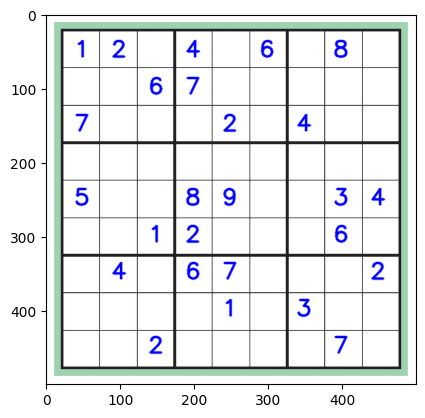

In [66]:
output_img_path = 'data/sudoku_images/empty.jpg'
img2 = cv2.imread(output_img_path)
img2 = cv2.resize(img2,(500, 500))
for i in range(9):
    for j in range(9):
        x = j * 50
        y = i * 50
        if task[i][j]!=0:
            cv2.putText(img2, str(task[i][j]), (x+38, y+57), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        else: continue
cv2.imwrite('data/sudoku_images/task1.jpg', img2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))


 <a id="1"></a>
# **<span style="color:#4686C8;">Sudoku Podskazka</span>**

In [ ]:
# # cap = cv2.VideoCapture('data/su_videos/video_su.mp4')
# # cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture('data/su_videos/IMG_6682asfdge.mp4')



# while True:
#     ret, frame = cap.read()
#     puzzle1 = frame.copy()

# # def click_handler_or_helper(event, x, y, flags, param):
# #     su_puzzle1 = preprocess(puzzle1)

# #     # Finding the outline of the sudoku puzzle in the image
# #     su_contour_11 = su_puzzle1.copy()
# #     # su_contour_2 = sudoku_a.copy()
# #     su_contour1, hierarchy1 = cv2.findContours(su_puzzle1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# #     cv2.drawContours(su_contour_11, su_contour1, -1, (0,255,0), 3)

# #     black_img1 = np.zeros((450,450,3), np.uint8)
# #     su_biggest1, su_maxArea1 = main_outline(su_contour1)
# #     su_imagewrap1 = 0
# #     if su_biggest1.size != 0:
# #         su_biggest1 = reframe(su_biggest1)
# #         # cv2.
# #         #drawContours(su_contour_2,su_biggest,-1, (0,255,0),10)
# #         su_pts11 = np.float32(su_biggest1)
# #         su_pts21 = np.float32([[0,0],[450,0],[0,450],[450,450]])
# #         su_matrix1 = cv2.getPerspectiveTransform(su_pts11,su_pts21)  
# #         su_imagewrap1 = cv2.warpPerspective(puzzle1,su_matrix1,(450,450))
# #         su_imagewrap1 =cv2.cvtColor(su_imagewrap1, cv2.COLOR_BGR2GRAY)
# #         # su_imagewrap1 = cv2.cvtColor(su_imagewrap1, cv2.COLOR_BGR2RGB)
# #     if event == cv2.EVENT_LBUTTONDOWN:
# #         row =
# #         #y // 50
# #         col = x // 50
# #         if task[row][col] != 0:
# #             print
# #             #(f"ячейка ({row}, {col}): {task[row][col]}")
# #         else:
# #             result = solve_sudoku(task)
# #             #cv2.putText
# #             #(img, str(result[row][col]), (x+25, y+45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
# #             plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


 <a id="1"></a>
# **<span style="color:#4686C8;">About Dataset</span>**

In this dataset, symbols used in both English and Kannada are available.

In the English language, Latin script (excluding accents) and Hindu-Arabic numerals are used. For simplicity we call this the "English" characters set. Our dataset consists of:

64 classes (0-9, A-Z, a-z)
7705 characters obtained from natural images
3410 hand drawn characters using a tablet PC
62992 synthesised characters from computer fonts
This gives a total of over 74K images (which explains the name of the dataset).

link: http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

Resources:

https://www.youtube.com/watch?v=G_UYXzGuqvM

https://www.kaggle.com/yashchoudhary/deep-sudoku-solver-multiple-approaches

https://www.youtube.com/watch?v=QR66rMS_ZfA

https://chat.openai.com/

<a id="11"></a>
<h1 style='background:#4686C8; border:0; color:#5CE1E6'><center>Тхе энд</center></h1> 

<h1><center>THE END</center></h1> 